In [199]:
import pandas as pd
import time 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,RobustScaler,MinMaxScaler,StandardScaler
import joblib

# Load dataset
data_df = pd.read_csv('games.csv')
print("Dataset shape:", data_df.shape)
data_df.info()

Dataset shape: (20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memor

In [200]:
start = time.time()

In [201]:
# Rename columns for easier reference
data_df.columns = [
    'Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 
    'Number_of_Turns', 'Game_Status', 'Winner', 'Time_Increment',
    'White_ID', 'White_Rating', 'Black_ID',
    'Black_Rating', 'Moves',
    'Opening_Eco', 'Opening_Name', 'Opening_Ply'
]

In [202]:
# print("Columns in DataFrame: \n",data_df.columns)
# print("Info: \n",data_df.info)
# print("NA Values: \n",data_df.isna().sum())
# print("Null Values: \n",data_df.isnull().sum())

### Simplification of Data

In [203]:
#1. Calculate Game Difference by Simplyfying Sart Time and End Time.

# Convert timestamps to raw numeric values in minutes
data_df['Start_Time'] = data_df['Start_Time'] / 60000
data_df['End_Time'] = data_df['End_Time'] / 60000

# Calculate 'Game_Duration' in minutes (no need to use .dt.total_seconds())
data_df['Game_Duration_(M)'] = data_df['End_Time'] - data_df['Start_Time']

# Handle cases with zero duration (if Start_Time == End_Time)
data_df.loc[data_df['Start_Time'] == data_df['End_Time'], 'Game_Duration_(M)'] = 1

# Remove rows where Game_Duration is 1 minute (assuming zero duration is invalid)
data_df = data_df[data_df['Game_Duration_(M)'] > 1]

# Remove rows where Game_Duration is divisible by 10
data_df = data_df[data_df['Game_Duration_(M)'] % 10 != 0]

# Remove duplicate rows based on 'Game_Duration' (keep=False removes all duplicates)
data_df = data_df[~data_df['Game_Duration_(M)'].duplicated(keep=False)]

# Round 'Game_Duration' to 2 decimal places
data_df['Game_Duration_(M)'] = data_df['Game_Duration_(M)'].round(2)


In [204]:
# 2. Calculate Elo Difference
data_df['Elo_Difference'] = data_df['White_Rating'] - data_df['Black_Rating']

In [205]:
# 3. Categorize Game Duration
def categorize_duration(duration):
    if duration < 300:  # Less than 5 minutes
        return 'Short'
    elif duration < 900:  # 5-15 minutes
        return 'Medium'
    else:
        return 'Long'

data_df['Duration_Category'] = data_df['End_Time'] - data_df['Start_Time']
data_df['Duration_Category'] = data_df['Duration_Category'].apply(categorize_duration)

In [206]:
# 4. Opening Analysis
data_df['Opening'] = data_df['Opening_Name']

In [207]:
# 5. Time per Move
data_df['Time_Per_Move_(S)'] = (data_df['Game_Duration_(M)'] * 60) / data_df['Number_of_Turns']
data_df['Time_Per_Move_(S)'] = data_df['Time_Per_Move_(S)'].round(2)

In [208]:
# 6. Elo Rating Tier
bins = [0, 1200, 1600, 2000, float('inf')]
labels = ['Beginner', 'Intermediate', 'Advanced', 'Master']
data_df['White_Rating_Tier'] = pd.cut(data_df['White_Rating'], bins=bins, labels=labels)
data_df['Black_Rating_Tier'] = pd.cut(data_df['Black_Rating'], bins=bins, labels=labels)


In [209]:
#7. Outlier Detection and Removal

Q1_duration = data_df['Game_Duration_(M)'].quantile(0.25)
Q3_duration = data_df['Game_Duration_(M)'].quantile(0.75)

Q1_time = data_df['Time_Per_Move_(S)'].quantile(0.25)
Q3_time = data_df['Time_Per_Move_(S)'].quantile(0.75)

# Calculate IQR for both columns
IQR_duration = Q3_duration - Q1_duration
IQR_time = Q3_time - Q1_time

# Define the lower and upper bounds for outliers
lower_bound_duration = Q1_duration - 1.5 * IQR_duration
upper_bound_duration = Q3_duration + 1.5 * IQR_duration

lower_bound_time = Q1_time - 1.5 * IQR_time
upper_bound_time = Q3_time + 1.5 * IQR_time

# Identify outliers in both columns
outliers_duration = data_df[(data_df['Game_Duration_(M)'] < lower_bound_duration) | (data_df['Game_Duration_(M)'] > upper_bound_duration)]
outliers_time = data_df[(data_df['Time_Per_Move_(S)'] < lower_bound_time) | (data_df['Time_Per_Move_(S)'] > upper_bound_time)]

# Combine both outliers (if any game is an outlier in either column, it's an outlier in the dataset)
outliers = pd.concat([outliers_duration, outliers_time]).drop_duplicates()

# Remove outliers from the main dataframe
data_df = data_df[~data_df.index.isin(outliers.index)]

# Save the outliers to a separate CSV file
# outliers.to_csv('outliers.csv', index=False)

In [210]:
data_df.columns

Index(['Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 'Number_of_Turns',
       'Game_Status', 'Winner', 'Time_Increment', 'White_ID', 'White_Rating',
       'Black_ID', 'Black_Rating', 'Moves', 'Opening_Eco', 'Opening_Name',
       'Opening_Ply', 'Game_Duration_(M)', 'Elo_Difference',
       'Duration_Category', 'Opening', 'Time_Per_Move_(S)',
       'White_Rating_Tier', 'Black_Rating_Tier'],
      dtype='object')

## Basic Visualization for understanding data better

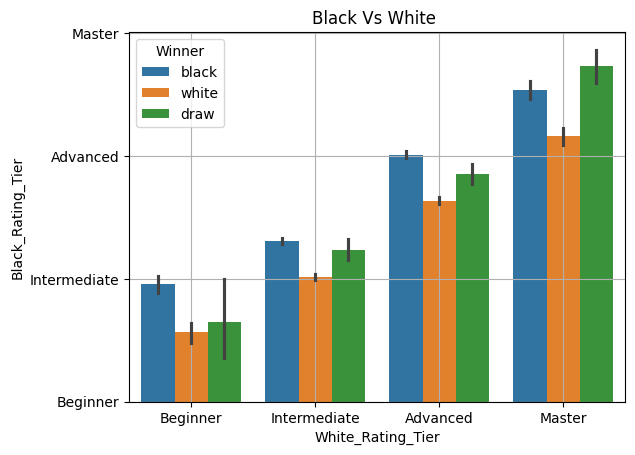

In [211]:
sns.barplot(data=data_df,x = "White_Rating_Tier", y = "Black_Rating_Tier", hue="Winner")
plt.title("Black Vs White ")
plt.grid(True)
plt.gca().invert_yaxis()

plt.show()

C:\Users\Kshitish Pandit\AppData\Local\Temp\ipykernel_13984\292247264.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d",hue= None)


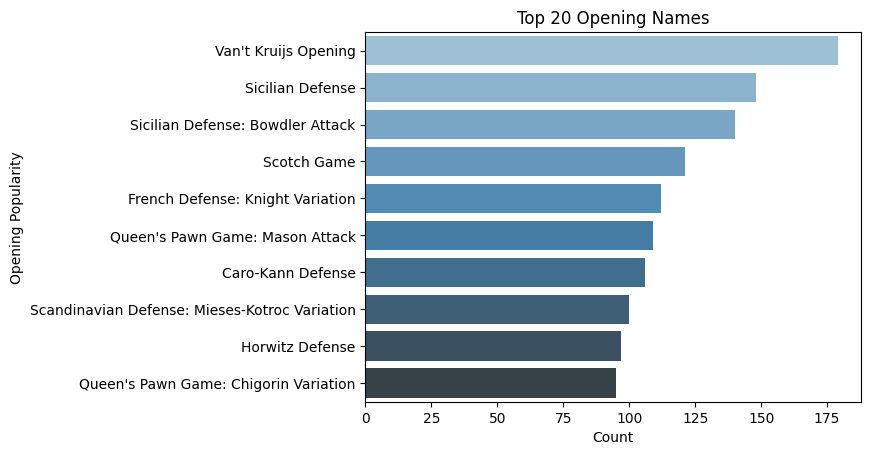

In [212]:
# Calculate the top 10 most frequent opening names.
top_openings = data_df['Opening'].value_counts().head(10)

# Create the bar plot for top openings
sns.barplot(x=top_openings.values, y=top_openings.index, palette="Blues_d",hue= None)
plt.title("Top 20 Opening Names")
plt.xlabel("Count")
plt.ylabel("Opening Popularity")
plt.show()

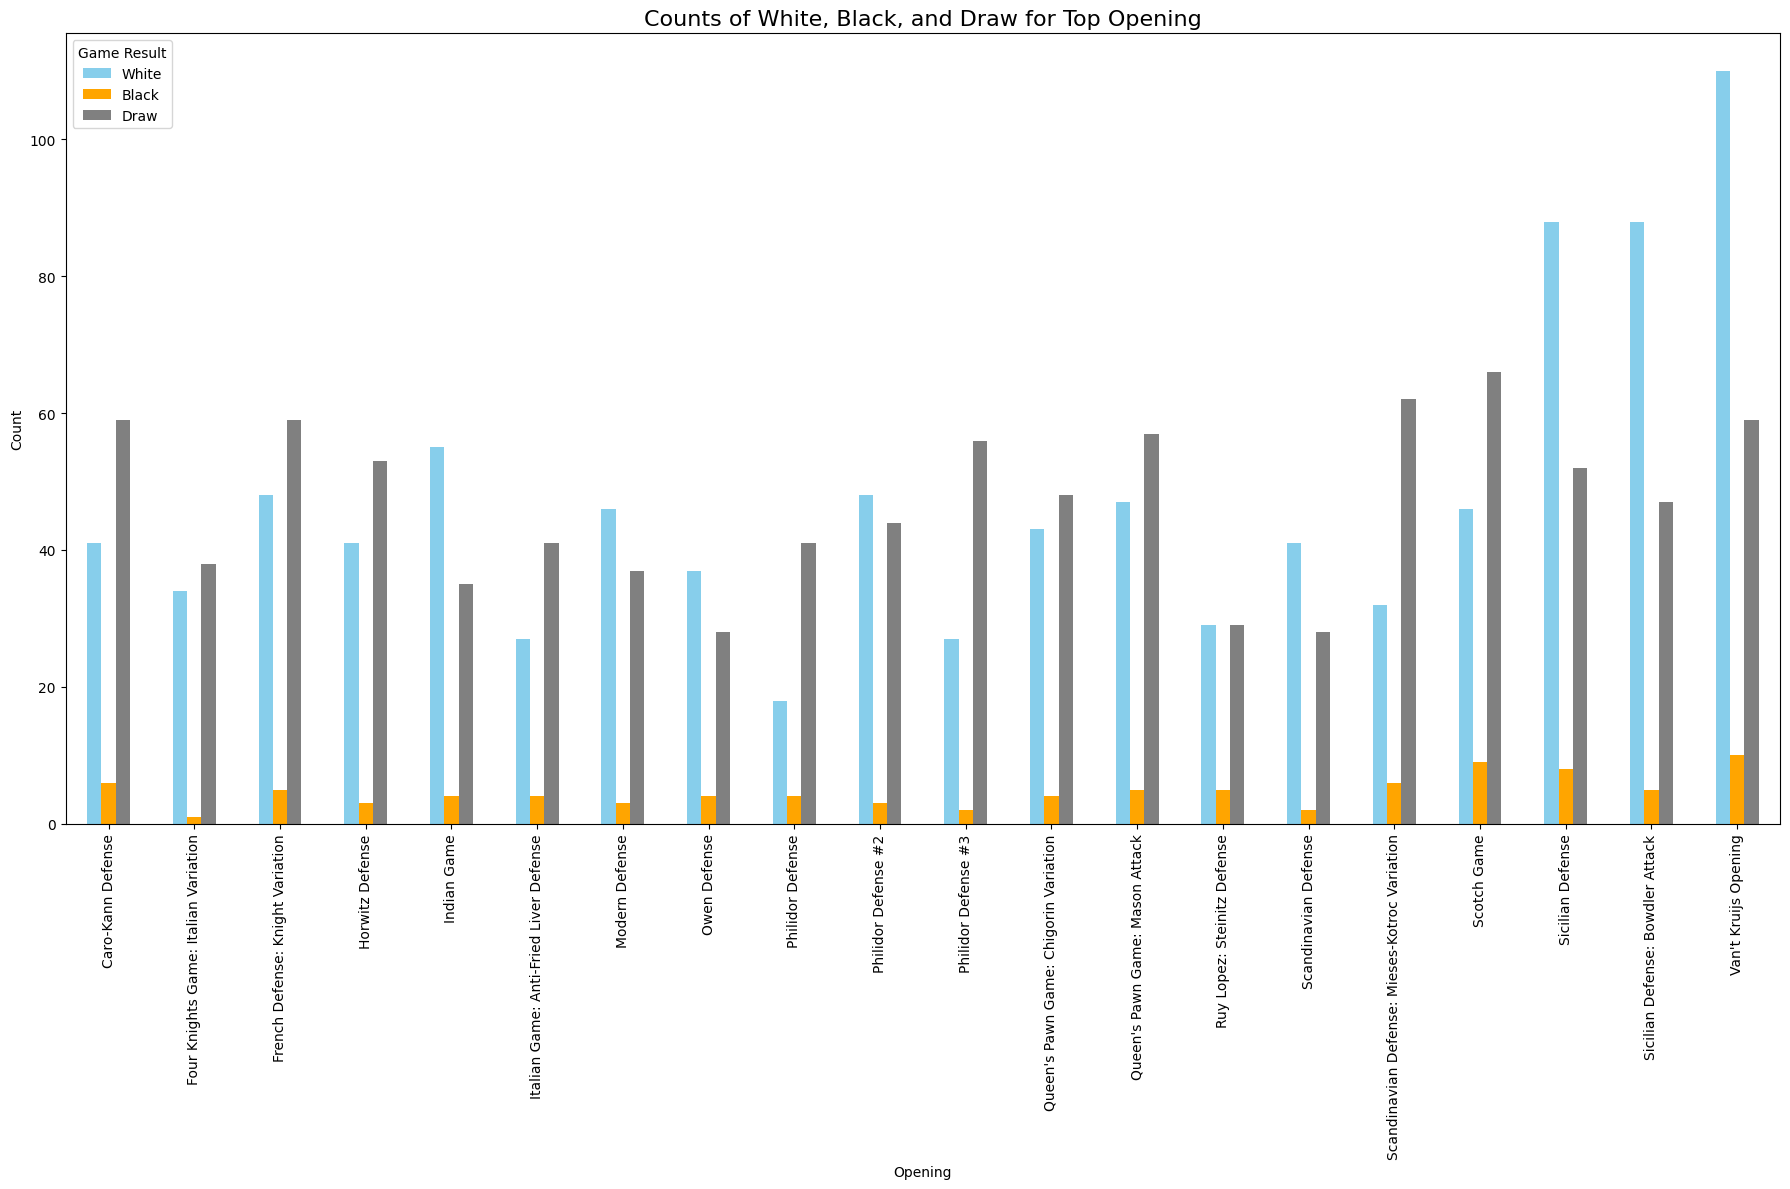

In [213]:
# Get the top 20 most common openings
top_openings = data_df['Opening'].value_counts().head(20).index

# Filter data for the top 20 openings
filtered_data = data_df[data_df['Opening'].isin(top_openings)]

# Group by 'Opening' and 'Winner' to count occurrences of 'white', 'black', and 'draw'
counts = filtered_data.groupby(['Opening', 'Winner']).size().unstack(fill_value=0)

counts.plot(
    kind='bar', 
    figsize=(18, 12), 
    stacked=False,  # Separate bars for each result type
    color=['skyblue', 'orange', 'gray']  # Colors for white, black, and draw
)

plt.title('Counts of White, Black, and Draw for Top Opening', fontsize=16)
plt.xlabel('Opening')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.legend(title="Game Result", labels=['White', 'Black', 'Draw'])
plt.tight_layout() 


plt.show()


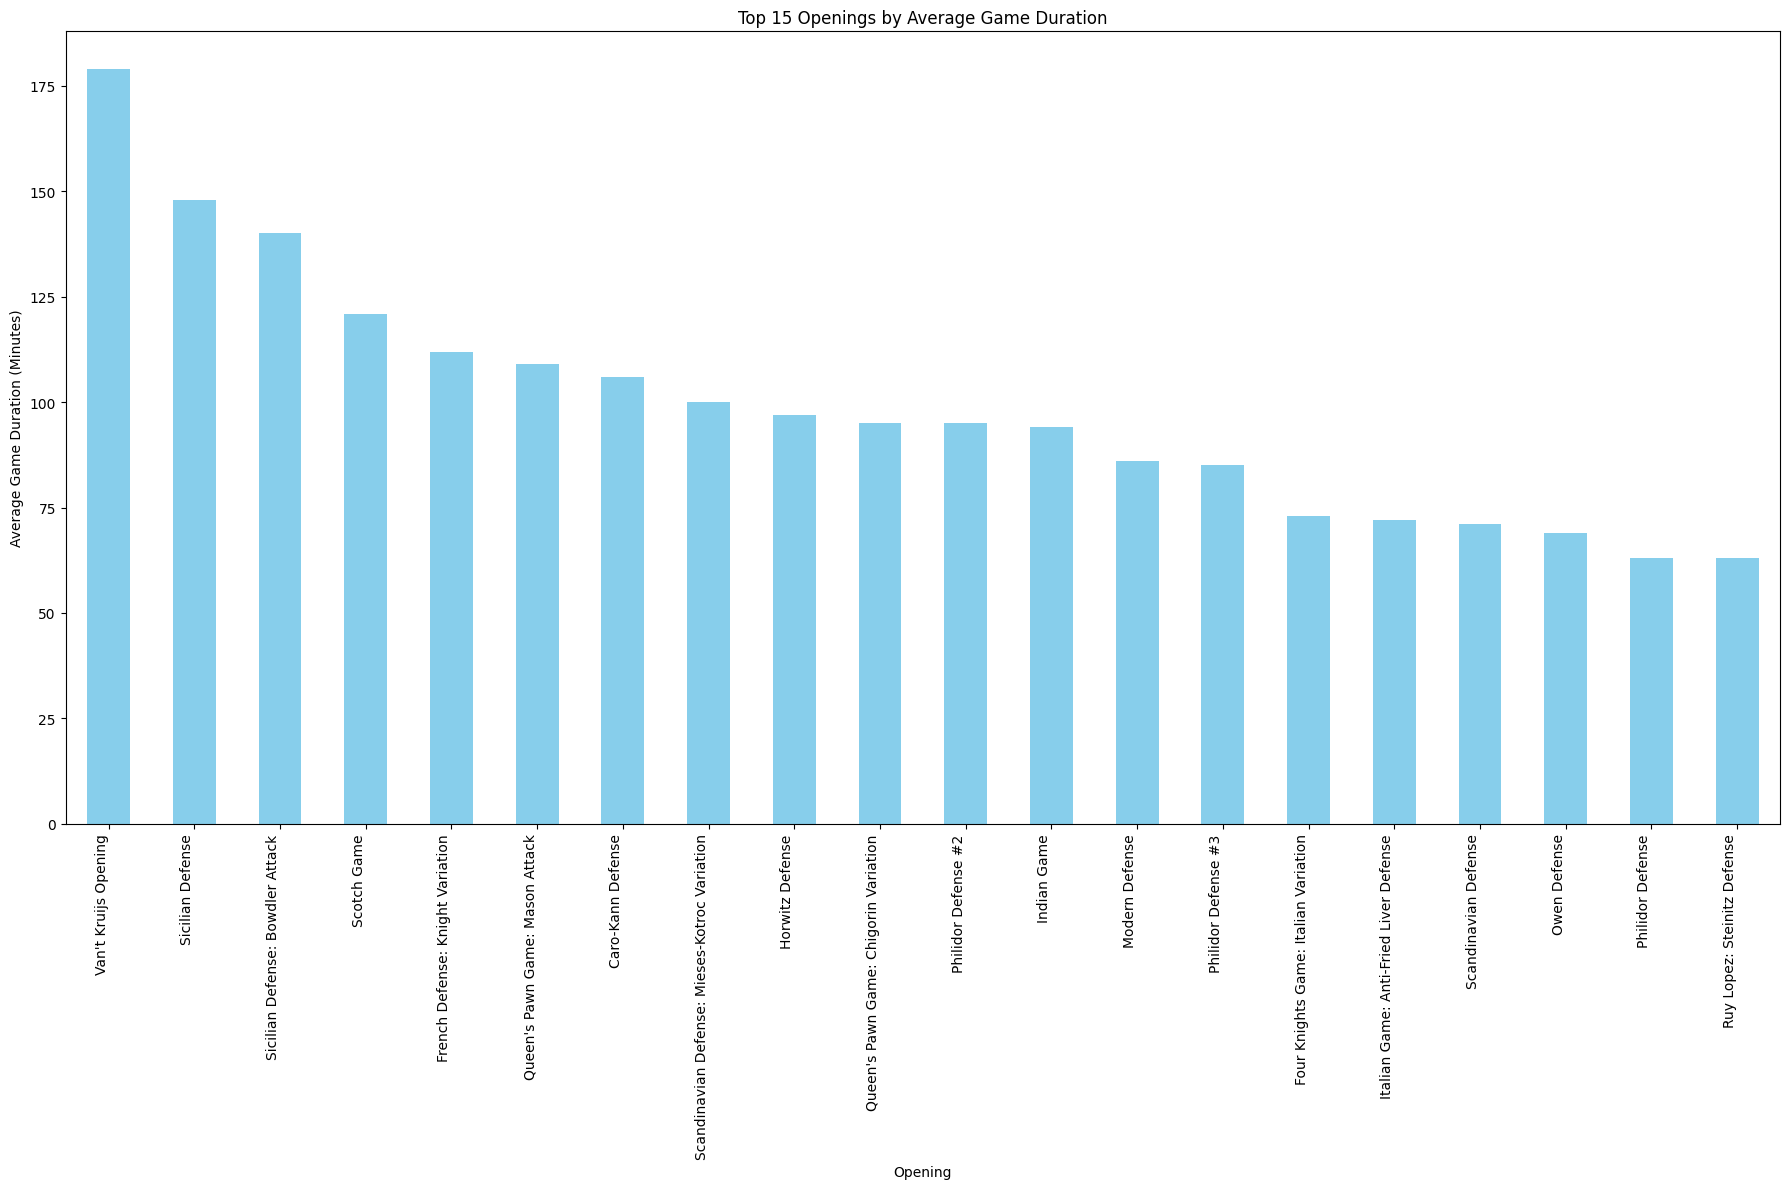

In [214]:
# Group by 'Opening' and calculate the mean of 'Game_Duration_(M)'
avg_duration = data_df.groupby('Opening')['Game_Duration_(M)'].mean().sort_values(ascending=False)

# Select the top 15 openings based on average game duration
top_15_openings = data_df['Opening'].value_counts().head(20)

top_15_openings.plot(kind='bar', figsize=(18, 12), color='skyblue')
plt.title('Top 15 Openings by Average Game Duration')
plt.xlabel('Opening')
plt.ylabel('Average Game Duration (Minutes)')
plt.xticks(rotation=90, ha='right')  
plt.tight_layout()
plt.show()

### Feature Enginerring

In [215]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8723 entries, 9288 to 20057
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Game_ID            8723 non-null   object  
 1   Rated_(T/F)        8723 non-null   bool    
 2   Start_Time         8723 non-null   float64 
 3   End_Time           8723 non-null   float64 
 4   Number_of_Turns    8723 non-null   int64   
 5   Game_Status        8723 non-null   object  
 6   Winner             8723 non-null   object  
 7   Time_Increment     8723 non-null   object  
 8   White_ID           8723 non-null   object  
 9   White_Rating       8723 non-null   int64   
 10  Black_ID           8723 non-null   object  
 11  Black_Rating       8723 non-null   int64   
 12  Moves              8723 non-null   object  
 13  Opening_Eco        8723 non-null   object  
 14  Opening_Name       8723 non-null   object  
 15  Opening_Ply        8723 non-null   int64   
 16  Game_Du

# *Encoding*

In [216]:
#Label Encoding
le = LabelEncoder()
encoded_moves = le.fit_transform(data_df['Moves'])
data_df['Moves_Encoded'] = encoded_moves

encoded_openings = le.fit_transform(data_df['Opening'])
data_df['Opening_Encoded'] = encoded_openings

rating_tier_mapping = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2, 'Master': 3}
# Apply the mapping to the 'Rating_Tier' column
data_df['White_Rating_Tier_Encoded'] = data_df['White_Rating_Tier'].map(rating_tier_mapping)
data_df['Black_Rating_Tier_Encoded'] = data_df['Black_Rating_Tier'].map(rating_tier_mapping)

#Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
columns_to_encode = ['Rated_(T/F)', 'Game_Status', 'Winner', 'Opening_Eco','Duration_Category']

for col in columns_to_encode:
    data_df[f"{col}_Encoded"] = ordinal_encoder.fit_transform(data_df[[col]])
joblib.dump(ordinal_encoder, 'ordinal_encoder.pkl') 

['ordinal_encoder.pkl']

In [217]:
# Correct way to select multiple columns from the DataFrame
Original_df = data_df[['Moves', 'Opening']]
# Original_df.to_csv('Removed.csv')

# Metrics for Better Data
- Move Efficiency Score
- Acccuracy Metric
- Error Rate
- Tempo Efficiency
- Positional Exploitation Rate
- Game Duration Efficiency


C:\Users\Kshitish Pandit\AppData\Local\Temp\ipykernel_13984\214549387.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_openings.index, y=top_openings.values, palette='Blues_d')


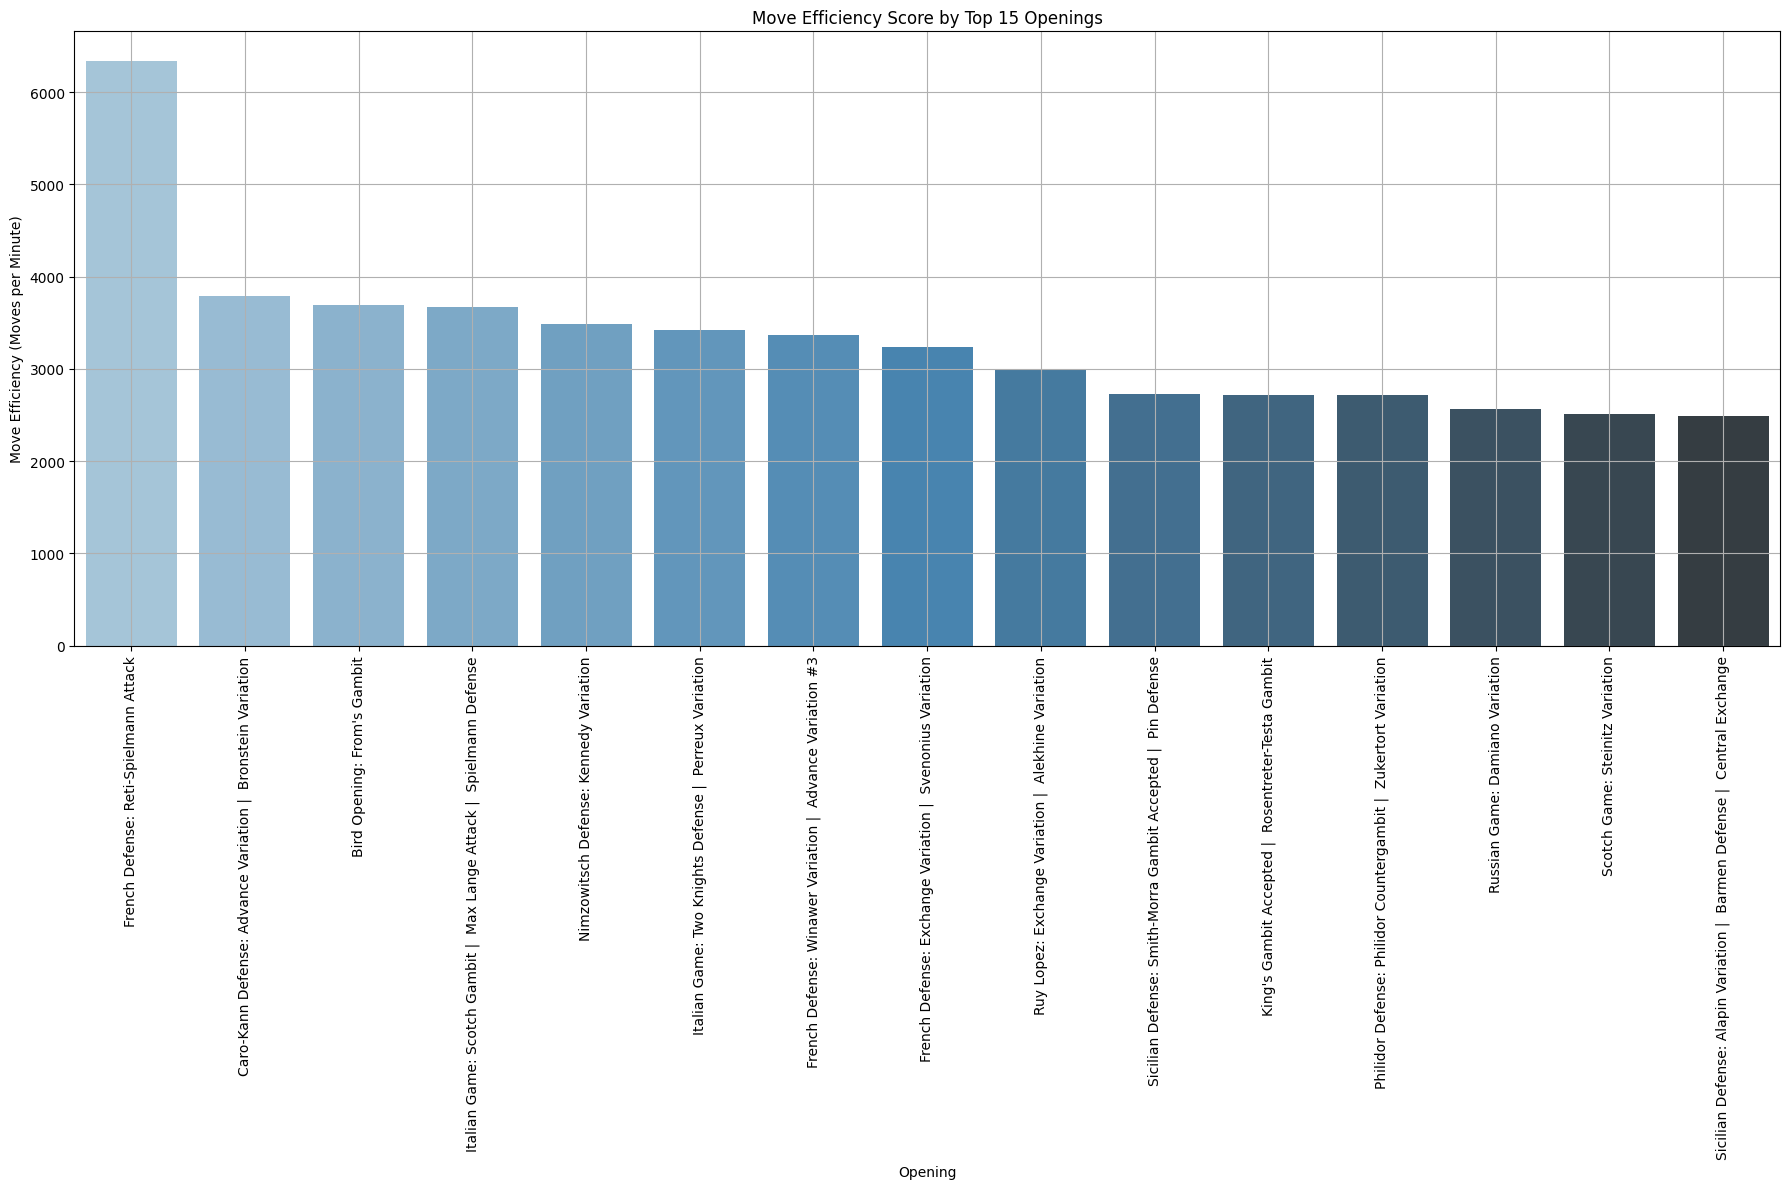

In [218]:
# Calculate Move Efficiency as Moves divided by Game Duration
data_df['Move_Efficiency_Score'] = data_df['Moves_Encoded'] / data_df['Game_Duration_(M)']
data_df['Move_Efficiency_Score'] = data_df['Move_Efficiency_Score'].round(2) 
# Aggregate Move Efficiency by Opening
opening_efficiency = data_df.groupby('Opening')['Move_Efficiency_Score'].mean().sort_values(ascending=False)

top_openings = opening_efficiency.head(15)
plt.figure(figsize=(18, 12))
sns.barplot(x=top_openings.index, y=top_openings.values, palette='Blues_d')
plt.title('Move Efficiency Score by Top 15 Openings')
plt.xlabel('Opening')
plt.grid(True)
plt.ylabel('Move Efficiency (Moves per Minute)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


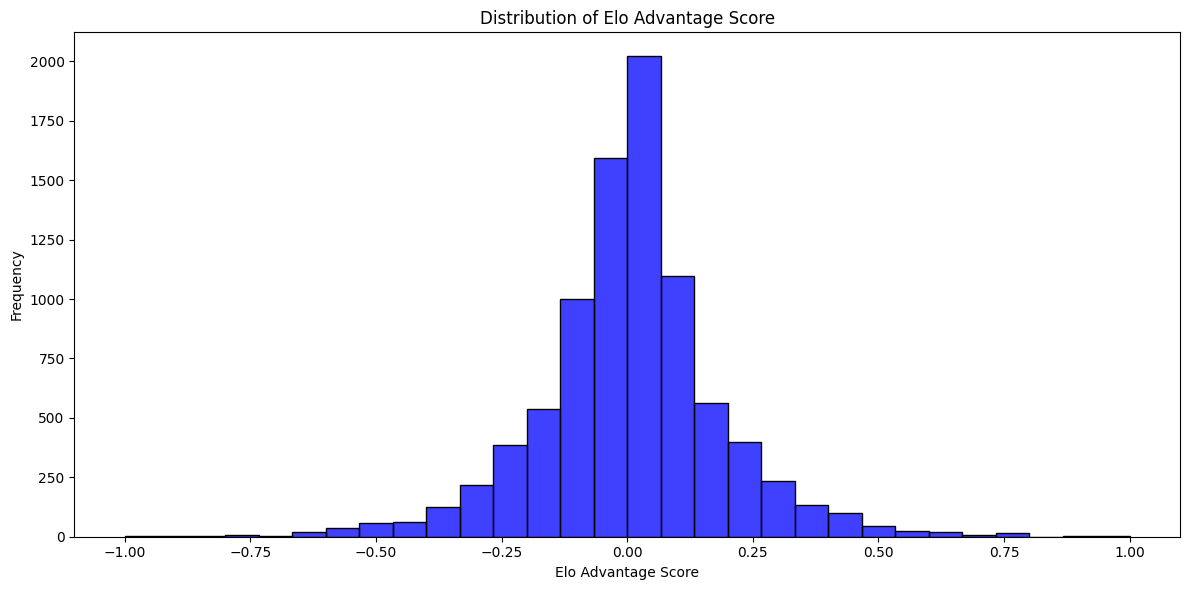

In [219]:
#Calculate Elo Advantage Score
data_df['Elo_Advantage_Score'] = data_df['Elo_Difference'] / abs(data_df['Elo_Difference']).max()
data_df['Elo_Advantage_Score'] =data_df['Elo_Advantage_Score'].round(2)

plt.figure(figsize=(12, 6))
sns.histplot(data_df['Elo_Advantage_Score'], bins=30, color='blue')
plt.title('Distribution of Elo Advantage Score')
plt.xlabel('Elo Advantage Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


The dataset is mostly balanced, with a high concentration of games between players of similar Elo strength. This aligns with competitive platforms, where matchmaking tries to pair players of similar skill levels.

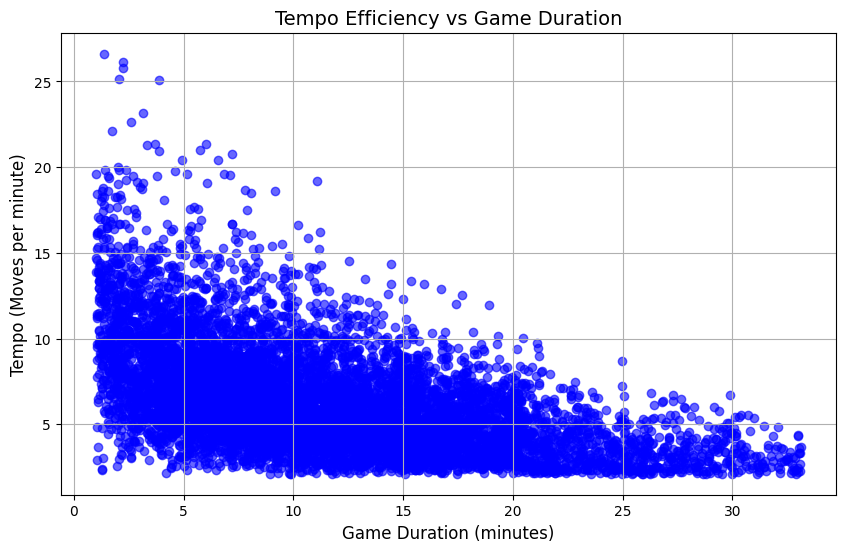

In [220]:
#Calculate GAME TEMPO
data_df['Tempo'] = data_df['Number_of_Turns'] / data_df['Game_Duration_(M)'].round(2) 
data_df['Tempo'] = data_df['Tempo'].round(2) 

plt.figure(figsize=(10,6))
plt.scatter(data_df['Game_Duration_(M)'], data_df['Tempo'], color='b', alpha=0.6)

# Adding title and labels
plt.title('Tempo Efficiency vs Game Duration', fontsize=14)
plt.xlabel('Game Duration (minutes)', fontsize=12)
plt.ylabel('Tempo (Moves per minute)', fontsize=12)

# Display the plot
plt.grid(True)
plt.show()

      Move_Efficiency  Time_Per_Move_(S)    PER
9288             3.27              18.32  17.85
9290             3.70              16.22  22.81
9292             6.29               9.54  65.93
9293             7.46               8.04  92.79
9294             4.06              14.78  27.47


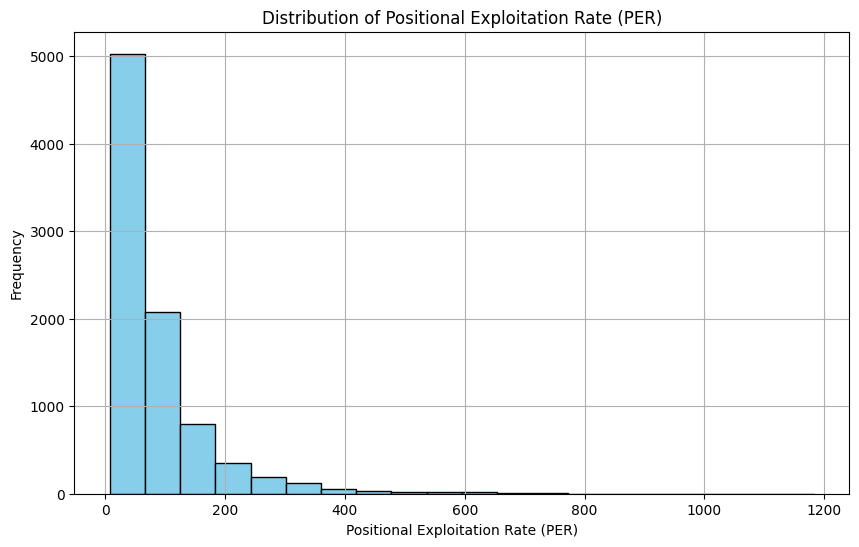

In [221]:
data_df['Move_Efficiency'] = data_df['Number_of_Turns'] / data_df['Game_Duration_(M)'].round(2)
data_df['Move_Efficiency'] = data_df['Move_Efficiency'].round(2) 
# Calculate the simplified Positional Exploitation Rate (PER)
data_df['PER'] = (data_df['Move_Efficiency'] / data_df['Time_Per_Move_(S)']) * 100
data_df['PER'] = data_df['PER'].round(2) 
# Display the PER values for analysis
print(data_df[['Move_Efficiency', 'Time_Per_Move_(S)', 'PER']].head())

plt.figure(figsize=(10, 6))
plt.hist(data_df['PER'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Positional Exploitation Rate (PER)')
plt.xlabel('Positional Exploitation Rate (PER)')
plt.grid(True)
plt.ylabel('Frequency')
plt.show()

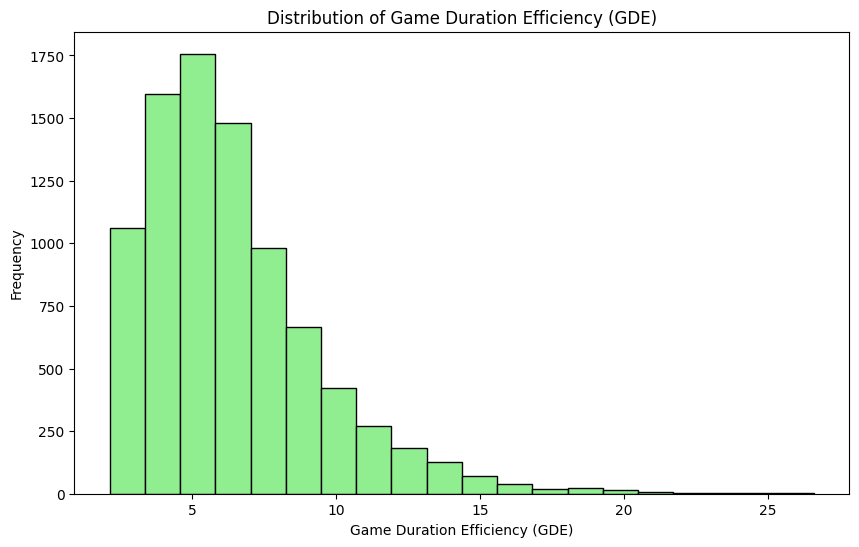

In [222]:
#Calculate Game Duration Efficiency
data_df['GDE'] = data_df['Number_of_Turns'] / data_df['Game_Duration_(M)']
data_df['GDE'] = data_df['GDE'].round(2) 
# Display the GDE values for analysis

plt.figure(figsize=(10, 6))
plt.hist(data_df['GDE'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution of Game Duration Efficiency (GDE)')
plt.xlabel('Game Duration Efficiency (GDE)')
plt.ylabel('Frequency')
plt.show()

In [223]:
# Feature Combination of Opening and Ratings
data_df['White_Rating_Tier_Encoded'] = data_df['White_Rating_Tier_Encoded'].astype(int)
data_df['Black_Rating_Tier_Encoded'] = data_df['Black_Rating_Tier_Encoded'].astype(int)
data_df['Opening_Encoded'] = data_df['Opening_Encoded'].astype(int)

# Now, you can safely perform arithmetic operations

# Create interaction features between white rating, black rating, and opening
data_df['White_Rating_Opening_Interaction'] = data_df['White_Rating_Tier_Encoded'] * data_df['Opening_Encoded']
data_df['Black_Rating_Opening_Interaction'] = data_df['Black_Rating_Tier_Encoded'] * data_df['Opening_Encoded']

data_df['Combined_Rating_Opening_Interaction'] = ((data_df['White_Rating_Tier_Encoded'] + data_df['Black_Rating_Tier_Encoded']) * data_df['Opening_Encoded'])

rating_opening_counts = (data_df.groupby(['Combined_Rating_Opening_Interaction']).size().reset_index(name='Player_Count'))

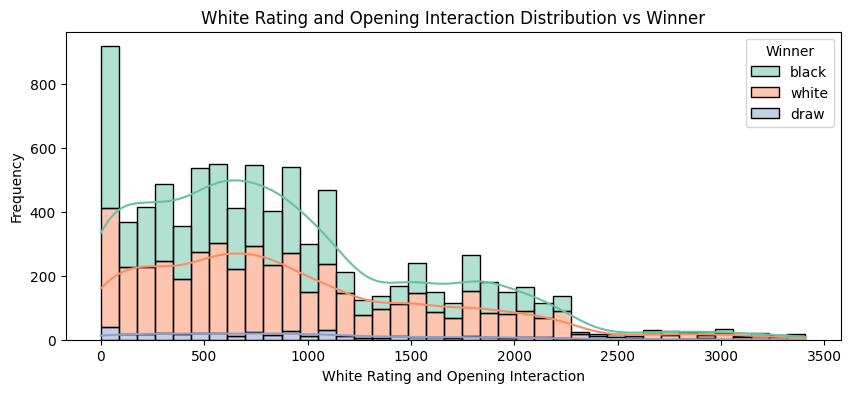

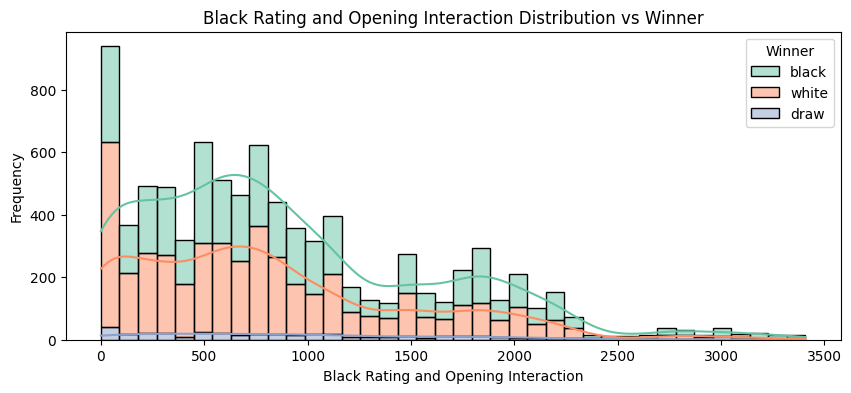

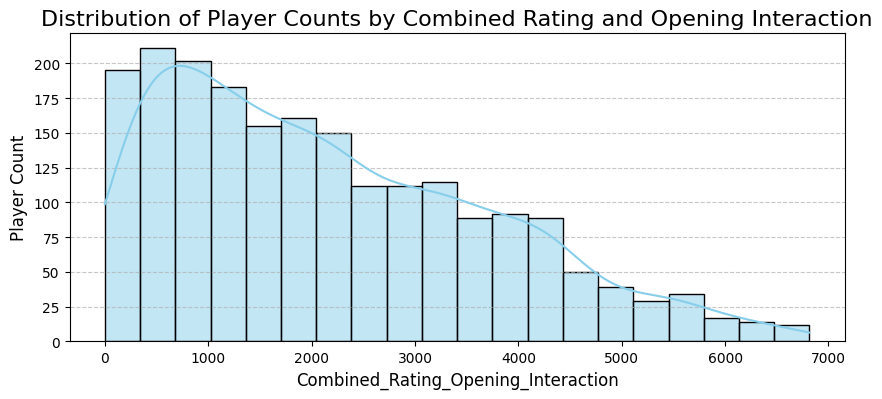

In [224]:
# Histplot for White Rating and Opening Interaction vs Win Rate
plt.figure(figsize=(10,4))
sns.histplot(data=data_df, x='White_Rating_Opening_Interaction', hue='Winner', kde=True, multiple="stack", palette="Set2")
plt.title('White Rating and Opening Interaction Distribution vs Winner')
plt.xlabel('White Rating and Opening Interaction')
plt.ylabel('Frequency')
plt.show()

# Histplot for Black Rating and Opening Interaction vs Win Rate
plt.figure(figsize=(10,4))
sns.histplot(data=data_df, x='Black_Rating_Opening_Interaction', hue='Winner', kde=True, multiple="stack", palette="Set2")
plt.title('Black Rating and Opening Interaction Distribution vs Winner')
plt.xlabel('Black Rating and Opening Interaction')
plt.ylabel('Frequency')
plt.show()

# Histplot for Combined Rating and Opening Interaction vs Win Rate
plt.figure(figsize=(10,4))
sns.histplot(
    data=rating_opening_counts,
    x='Combined_Rating_Opening_Interaction',
    bins=20,
    kde=True,
    color='skyblue'
)
plt.title('Distribution of Player Counts by Combined Rating and Opening Interaction', fontsize=16)
plt.xlabel('Combined_Rating_Opening_Interaction', fontsize=12)
plt.ylabel('Player Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [225]:
# New Interaction Features
# 1. Player Style Effectiveness
data_df['Style_Effectiveness'] = data_df['Tempo'] * data_df['Move_Efficiency']
data_df['Style_Effectiveness'] =data_df['Style_Effectiveness'].round(2)
# 2. Opening Efficiency
data_df['Opening_Efficiency'] = data_df['Opening_Encoded'] * data_df['Move_Efficiency']
data_df['Opening_Efficiency'] =data_df['Opening_Efficiency'].round(2)
# 3. Time Management Impact
data_df['Time_Efficiency_Score'] = data_df['Time_Per_Move_(S)'] * data_df['Move_Efficiency']
data_df['Time_Efficiency_Score'] =data_df['Time_Efficiency_Score'].round(2)
# 4. Opening Risk Score
data_df['Opening_Risk_Score'] = data_df['Opening_Encoded'] * data_df['Elo_Difference']
data_df['Opening_Risk_Score'] = data_df['Opening_Risk_Score'].round(2)
# 5. Game Complexity
data_df['Game_Complexity'] = (
    data_df['Number_of_Turns'] * data_df['Moves_Encoded'] / (data_df['Game_Duration_(M)'] + 1)
)
data_df['Game_Complexity'] = data_df['Game_Complexity'].round(2)
# 6. PER Adjusted by Elo Difference
data_df['PER_Adjusted'] = data_df['PER'] * data_df['Elo_Difference']
data_df['PER_Adjusted'] =data_df['PER_Adjusted'].round(2)



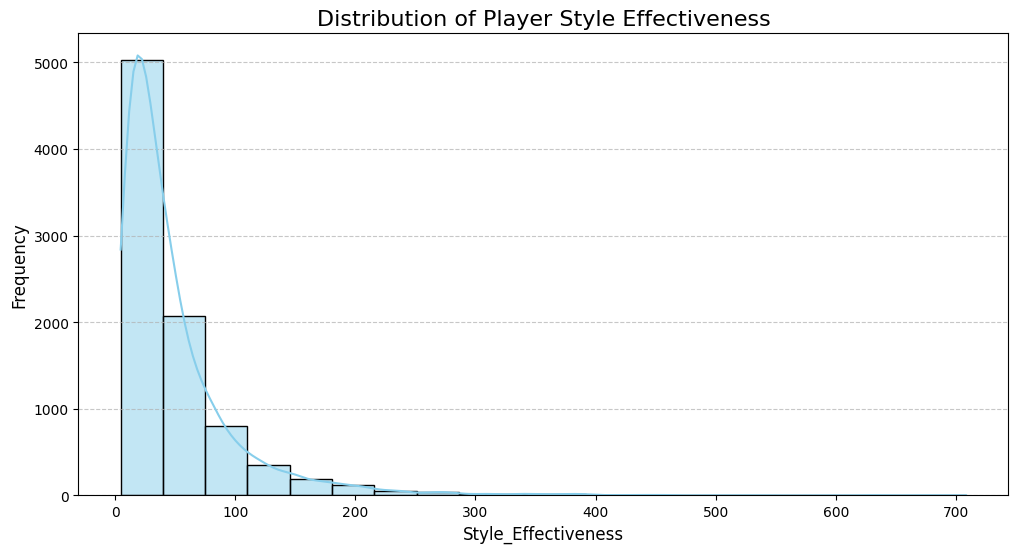

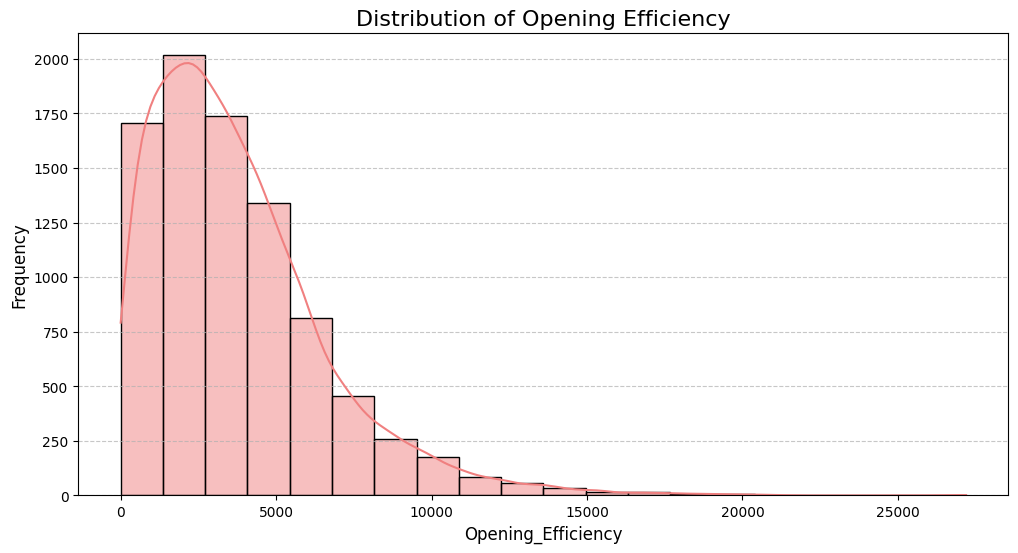

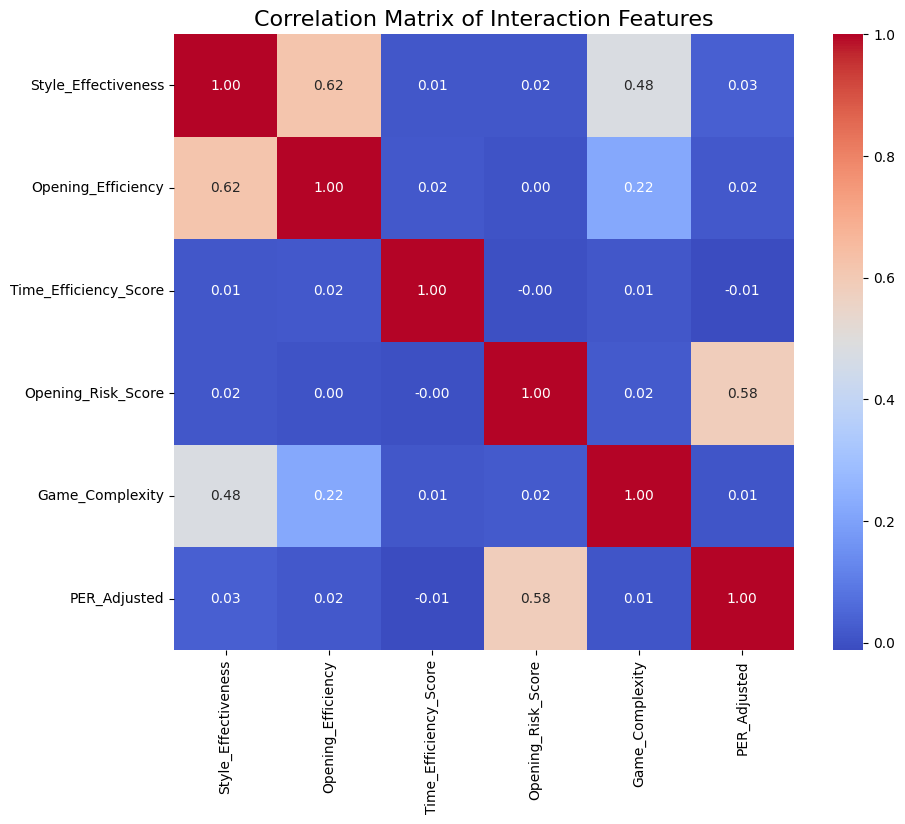

In [226]:
# Visualization
# Plot Style Effectiveness
plt.figure(figsize=(12, 6))
sns.histplot(data=data_df, x='Style_Effectiveness', bins=20, kde=True, color='skyblue')
plt.title('Distribution of Player Style Effectiveness', fontsize=16)
plt.xlabel('Style_Effectiveness', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Opening Efficiency
plt.figure(figsize=(12, 6))
sns.histplot(data=data_df, x='Opening_Efficiency', bins=20, kde=True, color='lightcoral')
plt.title('Distribution of Opening Efficiency', fontsize=16)
plt.xlabel('Opening_Efficiency', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Correlation Heatmap for Interaction Features
interaction_features = [
    'Style_Effectiveness', 'Opening_Efficiency', 'Time_Efficiency_Score',
    'Opening_Risk_Score', 'Game_Complexity', 'PER_Adjusted',
]
plt.figure(figsize=(10, 8))
sns.heatmap(data_df[interaction_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Interaction Features', fontsize=16)
plt.show()

In [227]:
# Step 1: Parse Base Time and Increment (convert to seconds)
data_df['Base_Time_S'] = data_df['Time_Increment'].apply(
    lambda x: int(x.split('+')[0]) * 60 if '+' in x else int(x.split('=')[0]) * 60
)
data_df['Increment_S'] = data_df['Time_Increment'].apply(
    lambda x: int(x.split('+')[1]) if '+' in x else (int(x.split('=')[1]) if '=' in x else 0)
)

# Step 2: Calculate Effective Total Time
data_df['Effective_Total_Time'] = (
    data_df['Base_Time_S'] + data_df['Increment_S'] * data_df['Number_of_Turns']
)

# Step 3: Calculate Total Time Spent During the Game
# We multiply the average time per move with the number of moves, including the increment.
data_df['Total_Time_Spent'] = (
    (data_df['Time_Per_Move_(S)'] + data_df['Increment_S']) * data_df['Number_of_Turns']
)

# Step 4: Calculate Remaining Time at the End of the Game
# Remaining time is the total effective time minus the time spent
data_df['Remaining_Time_S'] = data_df['Effective_Total_Time'] - data_df['Total_Time_Spent']

# Ensure no negative remaining time (if time spent exceeds the total time)
data_df['Remaining_Time_S'] = data_df['Remaining_Time_S'].apply(lambda x: max(0, x))

# Step 5: Adjusted Per-Move Time Calculation
# Adjust per-move time by subtracting remaining time and dividing by number of moves
data_df['Adjusted_Time_Per_Move'] = (
    data_df['Effective_Total_Time'] - data_df['Remaining_Time_S']
) / data_df['Number_of_Turns']
data_df['Adjusted_Time_Per_Move'] = data_df['Adjusted_Time_Per_Move'].fillna(0)  # Handle division by zero

# Step 6: Calculate Phases (Opening, Middle, Endgame)
# Opening and Endgame each get 20% of total moves
data_df['Opening_Moves'] = data_df['Number_of_Turns'].apply(lambda x: max(10, int(0.2 * x)))  # Opening phase: 20% of total moves
data_df['Endgame_Moves'] = data_df['Number_of_Turns'].apply(lambda x: max(10, int(0.2 * x)))  # Endgame phase: 20% of total moves
data_df['Middle_Game_Moves'] = data_df['Number_of_Turns'] - data_df['Opening_Moves'] - data_df['Endgame_Moves']

# Calculate time spent in each phase using Adjusted Time per Move
data_df['Opening_Time'] = data_df['Opening_Moves'] * data_df['Adjusted_Time_Per_Move']
data_df['Middle_Game_Time'] = data_df['Middle_Game_Moves'] * data_df['Adjusted_Time_Per_Move']
data_df['Endgame_Time'] = data_df['Endgame_Moves'] * data_df['Adjusted_Time_Per_Move']

# Step 7: Calculate Increment Impact Percentage
data_df['Increment_Time'] = data_df['Increment_S'] * data_df['Number_of_Turns']
data_df['Increment_Impact_Percent'] = (
    data_df['Increment_Time'] / data_df['Effective_Total_Time']
) * 100
data_df['Increment_Impact_Percent'] = data_df['Increment_Impact_Percent'].fillna(0)  # Handle NaN values

In [228]:

# Drop specific columns
data_df = data_df.drop([
                        'Game_ID',
                        'Start_Time',
                        'End_Time',
                        'Duration_Category',
                        'White_ID',
                        'Black_ID',
                        'White_Rating',
                        'Black_Rating',
                        'Opening_Name',
                        'Moves',
                        'Opening',
                        'White_Rating_Tier',
                        'Black_Rating_Tier',
                        'GDE',
                        'Tempo',
                        'Style_Effectiveness',
                        'Combined_Rating_Opening_Interaction',
                        'Move_Efficiency', 
                        'Elo_Difference',
                        'Opening_Efficiency',
                        'Base_Time_S',          
                        'Time_Increment',     
                        'Game_Complexity',      
                        'Increment_Time','Rated_(T/F)', 'Game_Status', 'Winner', 'Opening_Eco'
                        ]
, axis=1)

In [229]:
columns_to_scale = [
    'Move_Efficiency_Score', 'Elo_Advantage_Score','PER',
    'White_Rating_Opening_Interaction', 'Black_Rating_Opening_Interaction', 'Time_Efficiency_Score', 'Opening_Risk_Score', 'PER_Adjusted'
]

# Initialize the RobustScaler
scaler = MinMaxScaler(feature_range=(1, 100))

# Apply scaling to the selected columns
data_df[columns_to_scale] = scaler.fit_transform(data_df[columns_to_scale])
data_df[columns_to_scale] = data_df[columns_to_scale].round(3)
# Check the scaled values

columns_to_standard_scale = [
    'Opening_Ply', 'Game_Duration_(M)', 'Time_Per_Move_(S)', 'Moves_Encoded',
    'Increment_S', 'Effective_Total_Time', 'Total_Time_Spent', 'Remaining_Time_S',
    'Adjusted_Time_Per_Move', 'Opening_Moves', 'Endgame_Moves', 'Middle_Game_Moves',
    'Opening_Time', 'Middle_Game_Time', 'Endgame_Time', 'Increment_Impact_Percent'
]

# Initialize the scaler
scaler = MinMaxScaler()

# Apply MinMaxScaler() on the selected columns
data_df[columns_to_standard_scale] = scaler.fit_transform(data_df[columns_to_standard_scale])

In [230]:
organized_columns = [
    # Game Info    
    'Winner_Encoded',
    'Rated_(T/F)_Encoded',
    'Game_Status_Encoded',
    'Opening_Eco_Encoded',
    'Opening_Ply',

    # Game Time and Moves
    'Game_Duration_(M)',
    'Duration_Category_Encoded',
    'Time_Per_Move_(S)',
    'Moves_Encoded',
    'Opening_Encoded',

    # Rating Tiers
    'White_Rating_Tier_Encoded',
    'Black_Rating_Tier_Encoded',
    

    # Efficiency and Scores
    'Move_Efficiency_Score',
    'Elo_Advantage_Score',
    'PER',
    'White_Rating_Opening_Interaction',
    'Black_Rating_Opening_Interaction',
    'Time_Efficiency_Score',
    'Opening_Risk_Score',
    'PER_Adjusted',

    # Time Analysis
    'Increment_S',
    'Effective_Total_Time',
    'Total_Time_Spent',
    'Remaining_Time_S',
    'Adjusted_Time_Per_Move',

    # Game Phase Details
    'Opening_Moves',
    'Endgame_Moves',
    'Middle_Game_Moves',

    # Time Per Phase
    'Opening_Time',
    'Middle_Game_Time',
    'Endgame_Time',
    'Increment_Impact_Percent'
]

# Reorder the columns of the DataFrame
data_df = data_df[organized_columns]

In [231]:
print(data_df.columns)
print(data_df.info())

Index(['Winner_Encoded', 'Rated_(T/F)_Encoded', 'Game_Status_Encoded',
       'Opening_Eco_Encoded', 'Opening_Ply', 'Game_Duration_(M)',
       'Duration_Category_Encoded', 'Time_Per_Move_(S)', 'Moves_Encoded',
       'Opening_Encoded', 'White_Rating_Tier_Encoded',
       'Black_Rating_Tier_Encoded', 'Move_Efficiency_Score',
       'Elo_Advantage_Score', 'PER', 'White_Rating_Opening_Interaction',
       'Black_Rating_Opening_Interaction', 'Time_Efficiency_Score',
       'Opening_Risk_Score', 'PER_Adjusted', 'Increment_S',
       'Effective_Total_Time', 'Total_Time_Spent', 'Remaining_Time_S',
       'Adjusted_Time_Per_Move', 'Opening_Moves', 'Endgame_Moves',
       'Middle_Game_Moves', 'Opening_Time', 'Middle_Game_Time', 'Endgame_Time',
       'Increment_Impact_Percent'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 8723 entries, 9288 to 20057
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                

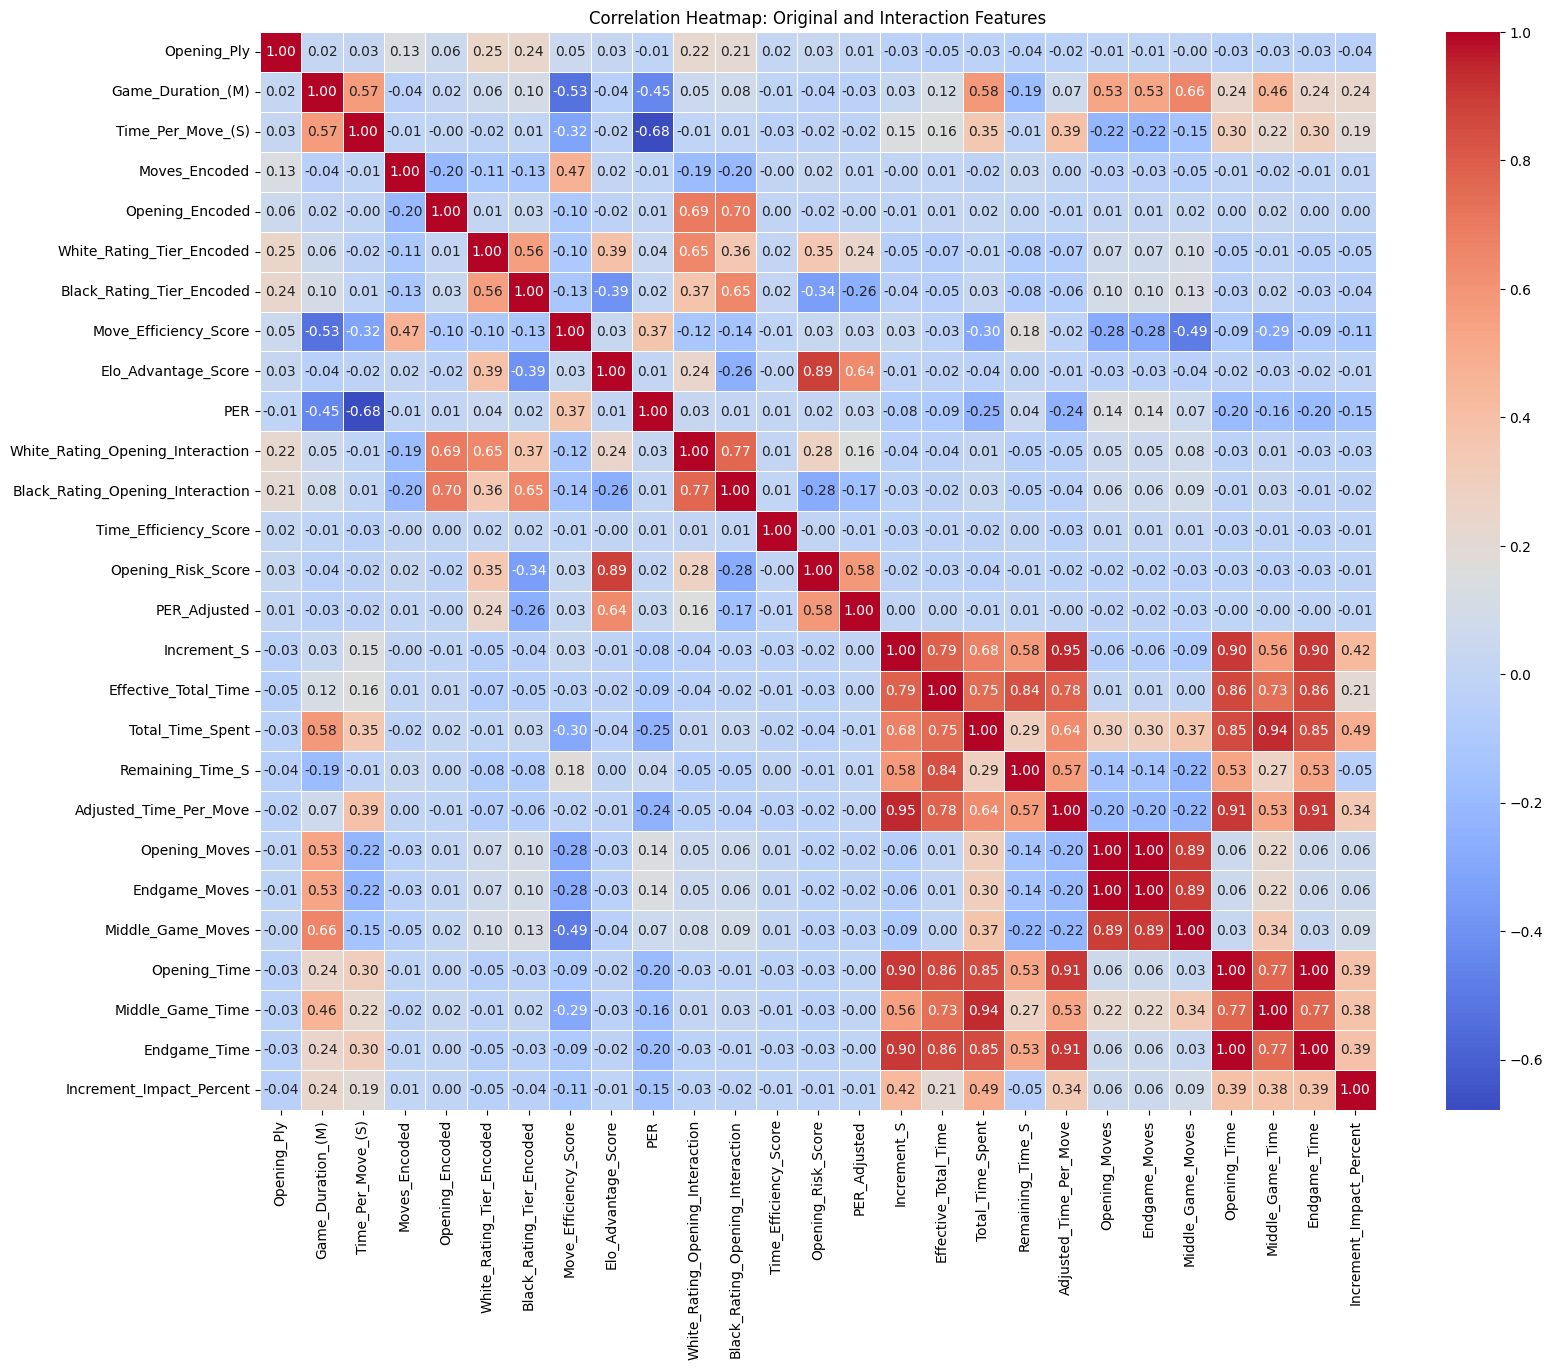

In [232]:
columns_for_correlation = [
    'Opening_Ply', 'Game_Duration_(M)', 'Time_Per_Move_(S)', 'Moves_Encoded',
    'Opening_Encoded', 'White_Rating_Tier_Encoded', 'Black_Rating_Tier_Encoded', 'Move_Efficiency_Score',
    'Elo_Advantage_Score', 'PER', 'White_Rating_Opening_Interaction', 'Black_Rating_Opening_Interaction', 
    'Time_Efficiency_Score', 'Opening_Risk_Score', 'PER_Adjusted', 'Increment_S', 'Effective_Total_Time', 
    'Total_Time_Spent', 'Remaining_Time_S', 'Adjusted_Time_Per_Move', 'Opening_Moves', 'Endgame_Moves', 
    'Middle_Game_Moves', 'Opening_Time', 'Middle_Game_Time', 'Endgame_Time', 'Increment_Impact_Percent'
]

# Calculate the correlation matrix
correlation_matrix = data_df[columns_for_correlation].corr()

# Plot the heatmap
plt.figure(figsize=(18, 14))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap: Original and Interaction Features")
plt.show()


In [233]:
data_df = data_df.round(3)
data_df.to_csv("Data1.csv")

In [234]:
end = time.time()
print(end-start)

3.9926249980926514
